# Simulate library

(c) 2020 Tom Röschinger. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT).

In [48]:
import numpy as np
import random
import string
import pandas as pd
import matplotlib.pyplot as plt
import cmdstanpy
import arviz as az
import bebi103
import numba

import wgregseq
%load_ext autoreload
%autoreload 2

wgregseq.plotting_style()
%matplotlib inline
# Get svg graphics from the notebook
%config InlineBackend.figure_format = 'svg' 

import bokeh.io

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In this notebook we will try to simulate the expression values for a dataset when the energy matrix is given. The purpose is that we want to use these datasets to try and identify the binding sites. We want to see for which dataset we can recover the underlying architecture. The log-likelihood function is the mutual information. So I expect that we can simply draw from this likelihood when both energy matrix and binding sites are given.

As input we will use a energy matrix from Reg-Seq. Therefore we first load in the wild type sequence, here for *ykge*.

In [57]:
seqs = pd.read_csv("../../data/RegSeq/wtsequences.csv", index_col=0)
seqs.head()

,name,start_site,rev,geneseq,ssdiff,offset
0,fdoH,4085867.0,rev,CATTATGGTATTCTGTTACAAACCCTTCCTGGATGGAGGGAAATTG...,0.0,0.0
3,sdaB,2928035.0,fwd,TACATATATTGCGCGCCCCGGAAGAAGTCAGATGTCGTTTAATGGG...,0.0,0.0
6,thiM,2185451.0,rev,TCTGGATGTCGTTCTGAAGGTGCTGGATTCATATATCAAATAATTT...,0.0,0.0
7,yedJ,2033449.0,rev,TTTTTCCTGTATTCACTGCCGTTGCGCAAAATTTATCTATTTGTTC...,0.0,0.0
9,ykgE,321511.0,fwd,TCGATTTCCCCATAAAATGTGAGCGATGCCGAAAGAAATAAAATTA...,0.0,0.0


In [58]:
sequence = seqs.loc[seqs["name"]=="ykgE", "geneseq"].values[0]
sequence

'TCGATTTCCCCATAAAATGTGAGCGATGCCGAAAGAAATAAAATTAGTTATTGCATTTGACGTTTGGATGAAAGATTATCATTTGTCATACAAATGAGGGGTGGTATGTTGCTAGCCAATTAAAAAAGAACGCCATATTTATTGATGATTGATCCCCCGG'

Now we load in the energy matrix (and do some cosmetics).

In [54]:
emat = pd.read_csv("../../data/RegSeq/ykgEarabinosedataset_alldone_with_largeMCMC194", delim_whitespace=True)[['val_A', 'val_C', 'val_G', 'val_T']]
emat.rename(columns={"val_A": "A", "val_C": "C", "val_G": "G", "val_T": "T"}, inplace=True)
emat.head()

,A,C,G,T
0,0.014540,0.001685,-0.022539,0.006314
1,0.023509,-0.002869,-0.023115,0.002475
2,-0.003412,0.020748,-0.016885,-0.000451
3,0.009721,-0.001487,-0.020443,0.012209
4,-0.011957,-0.000411,0.021063,-0.008694


Let's have a look at the sum of all mutation effects per position.

<BarContainer object of 160 artists>

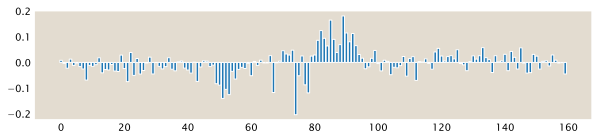

In [55]:
info = wgregseq.emat_to_information("../../data/RegSeq/ykgEarabinosedataset_alldone_with_largeMCMC194", sequence, old_format=True)

fig, ax = plt.subplots(figsize=(10,2))
plt.bar(range(len(info)), info)

We can easily compute the sum of all entries for the wild type.

In [56]:
wgregseq.sum_emat(sequence, emat)

-0.24144600000000022

Let's create some scrambles.

In [95]:
scrambles = wgregseq.create_scrambles_df(sequence, 10, 5, 100, number=50)
scrambles

,start_pos,stop_pos,sequence,center_pos
0,0.0,10.0,CGCTCCATTTCATAAAATGTGAGCGATGCCGAAAGAAATAAAATTA...,5.0
1,0.0,10.0,CTCTCGCTATCATAAAATGTGAGCGATGCCGAAAGAAATAAAATTA...,5.0
2,0.0,10.0,CTCTCCATTGCATAAAATGTGAGCGATGCCGAAAGAAATAAAATTA...,5.0
3,0.0,10.0,CTACCCGTTTCATAAAATGTGAGCGATGCCGAAAGAAATAAAATTA...,5.0
4,0.0,10.0,TTCCCCGTTACATAAAATGTGAGCGATGCCGAAAGAAATAAAATTA...,5.0
...,...,...,...,...
1545,150.0,160.0,TCGATTTCCCCATAAAATGTGAGCGATGCCGAAAGAAATAAAATTA...,155.0
1546,150.0,160.0,TCGATTTCCCCATAAAATGTGAGCGATGCCGAAAGAAATAAAATTA...,155.0
1547,150.0,160.0,TCGATTTCCCCATAAAATGTGAGCGATGCCGAAAGAAATAAAATTA...,155.0
1548,150.0,160.0,TCGATTTCCCCATAAAATGTGAGCGATGCCGAAAGAAATAAAATTA...,155.0


And compute the energies for the scrambles.

In [96]:
scrambles["effect"] = scrambles["sequence"].apply(wgregseq.sum_emat, args=(emat,))
scrambles.head()

,start_pos,stop_pos,sequence,center_pos,effect
0,0.0,10.0,CGCTCCATTTCATAAAATGTGAGCGATGCCGAAAGAAATAAAATTA...,5.0,-0.077694
1,0.0,10.0,CTCTCGCTATCATAAAATGTGAGCGATGCCGAAAGAAATAAAATTA...,5.0,-0.088115
2,0.0,10.0,CTCTCCATTGCATAAAATGTGAGCGATGCCGAAAGAAATAAAATTA...,5.0,-0.038665
3,0.0,10.0,CTACCCGTTTCATAAAATGTGAGCGATGCCGAAAGAAATAAAATTA...,5.0,-0.107392
4,0.0,10.0,TTCCCCGTTACATAAAATGTGAGCGATGCCGAAAGAAATAAAATTA...,5.0,-0.048393


Now we have a bunch of sequences, and their energies. To compute mutual information, we need the joint distribution of expression and energies. Therefore we cannot compute it without knowing expression. But what we should be able to do is to use the mutual information as a log-pdf over all possible expression data sets, and then draw some data sets. Obviously the space of all possible data sets is enormous, and I am not sure if we will succeed, but let's give it a try anyways. Nothing good ever came from not trying. (That's probably not true, but in computational and scientific context, I would say it is true. When thinking about driving on the highway with roller skates, I think not trying is better.)

array([1., 1., 1., 1., 2., 2., 2., 2., 3., 3., 3., 3.])